In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Define column names from UCI documentation
columns = [
    'ID', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity',
    'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS',
    'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caffeine', 'Cannabis', 'Chocolate',
    'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD',
    'Meth', 'Mushrooms', 'Nicotine', 'Semer', 'VSA'
]

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data"
df = pd.read_csv(url, header=None, names=columns)

In [3]:
# Focus only on demographic/personality features + Amphetamine use
selected_columns = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity',
                    'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore',
                    'Impulsive', 'SS', 'Amphet']
df = df[selected_columns]

# Map Amphetamine CL values into 3 classes
def map_amphetamine(x):
    if x == 'CL0':
        return 'Never Used'
    elif x == 'CL1':
        return 'Used Over a Decade Ago'
    else:
        return 'Used in Last Decade'

df['Amphet_Class'] = df['Amphet'].apply(map_amphetamine)

# Display clean sample
sample = df.head(10)[['Age', 'Gender', 'Education', 'Nscore', 'Impulsive', 'Amphet_Class']]
print(sample)

       Age   Gender  Education   Nscore  Impulsive            Amphet_Class
0  0.49788  0.48246   -0.05921  0.31287   -0.21712     Used in Last Decade
1 -0.07854 -0.48246    1.98437 -0.67825   -0.71126     Used in Last Decade
2  0.49788 -0.48246   -0.05921 -0.46725   -1.37983              Never Used
3 -0.95197  0.48246    1.16365 -0.14882   -1.37983              Never Used
4  0.49788  0.48246    1.98437  0.73545   -0.21712  Used Over a Decade Ago
5  2.59171  0.48246   -1.22751 -0.67825   -1.37983              Never Used
6  1.09449 -0.48246    1.16365 -0.46725   -0.21712              Never Used
7  0.49788 -0.48246   -1.73790 -1.32828    0.19268              Never Used
8  0.49788  0.48246   -0.05921  0.62967   -1.37983              Never Used
9  1.82213 -0.48246    1.16365 -0.24649   -1.37983  Used Over a Decade Ago


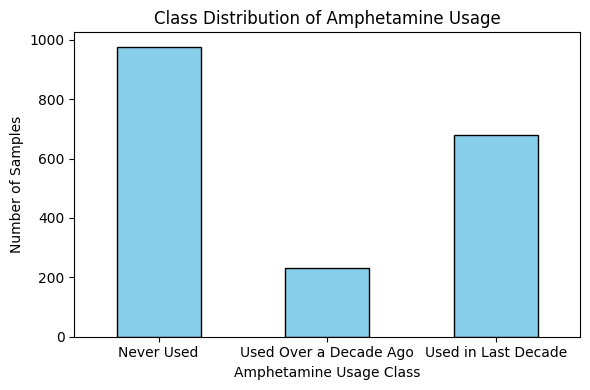

In [4]:
# Count of each class
class_counts = df['Amphet_Class'].value_counts().sort_index()

# Bar chart
plt.figure(figsize=(6,4))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Class Distribution of Amphetamine Usage')
plt.xlabel('Amphetamine Usage Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [5]:
# Example: create run_replication.py file directly in Colab
from pathlib import Path

code = """

import os
import argparse
import logging
from pathlib import Path
import subprocess
import sys
import json

from data_prep import load_and_preprocess_drug
from cigan_fallback import CIGAN
from train_eval import train_and_evaluate
from utils import set_global_seed

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s:%(message)s')

def try_clone_cigan(git_url='https://github.com/yuxiaohuang/research.git', clone_dir='external/cigan'):

    clone_path = Path(clone_dir)
    if clone_path.exists():
        logging.info(f"Found existing clone at {clone_path}")
        return True
    try:
        logging.info(f"Cloning {git_url} into {clone_dir} ...")
        subprocess.run(['git', 'clone', '--depth', '1', git_url, clone_dir], check=True)
        logging.info("Clone successful.")
        return True
    except Exception as e:
        logging.warning(f"Could not clone upstream repo: {e}")
        return False

def main(args):
    outdir = Path(args.output_dir)
    outdir.mkdir(parents=True, exist_ok=True)
    set_global_seed(42)

    # 1) Download + preprocess
    logging.info("Loading and preprocessing Drug Consumption dataset...")
    df, X_train, X_val, X_test, y_train, y_val, y_test, label_names = load_and_preprocess_drug(args.data_url, seed=42)
    logging.info(f"Train/Val/Test shapes: {X_train.shape}, {X_val.shape}, {X_test.shape}")
    # Save cleaned sample and class distribution
    df.head(10).to_csv(outdir / 'sample_clean.csv', index=False)
    class_counts = df['Amphet_Class'].value_counts()
    class_counts.to_csv(outdir / 'class_counts.csv')

    # 2) Try clone original CIGAN repository
    cloned = try_clone_cigan()

    # 3) Use fallback CIGAN implementation to augment minority classes
    logging.info("Fitting local CIGAN to augment minority classes...")
    cigan = CIGAN(random_seed=42)
    X_aug, y_aug = cigan.fit_resample(X_train, y_train, minor_classes='all', target_count='max')
    logging.info(f"Augmented training set shape: {X_aug.shape}")

    # 4) Train & evaluate classifier on baseline and on augmented data
    results = {}
    logging.info("Training and evaluating baseline classifier (no augmentation)...")
    results['baseline'] = train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, label_names, outdir / 'baseline')

    logging.info("Training and evaluating classifier trained on CIGAN-augmented data...")
    results['cigan'] = train_and_evaluate(X_aug, y_aug, X_val, y_val, X_test, y_test, label_names, outdir / 'cigan')

    # Save results JSON
    with open(outdir / 'results.json', 'w') as f:
        json.dump(results, f, indent=2)
    logging.info("Saved results to results.json")

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--data-url', type=str, default="https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data")
    parser.add_argument('--output-dir', type=str, default="results")
    args = parser.parse_args()
    main(args)

"""
Path("run_replication.py").write_text(code)

3015

In [6]:
# Example: create run_replication.py file directly in Colab
from pathlib import Path

code = """

# data_prep.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def load_and_preprocess_drug(data_url, seed=42, test_size=0.2, val_size=0.1):

    # Column names based on UCI documentation (subset)
    cols = [
        'ID', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity',
        'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS',
        # 18 drug columns - we only need 'Amphet' for target
        'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caffeine', 'Cannabis', 'Chocolate',
        'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD',
        'Meth', 'Mushrooms', 'Nicotine', 'Semer', 'VSA'
    ]
    df = pd.read_csv(data_url, header=None, names=cols)

    # Keep only features + Amphetamine target
    feature_cols = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity',
                    'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']
    df = df[feature_cols + ['Amphet']].copy()

    # Map string CL0..CL6 to classes per Huang & Ma
    def map_amp(x):
        if x == 'CL0':
            return 0  # Never Used
        elif x == 'CL1':
            return 1  # Used Over a Decade Ago
        else:
            return 2  # Used in Last Decade (CL2-CL6)
    df['Amphet_Class'] = df['Amphet'].apply(map_amp)

    # Replace categorical country/ethnicity/gender with simple encodings
    # Gender: original values are numeric floats; keep as-is
    # Education is numeric scaled; keep
    # For safety, fillna then scale numeric features
    X = df[feature_cols].copy()
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    imputer = SimpleImputer(strategy='median')
    X[numeric_cols] = imputer.fit_transform(X[numeric_cols])
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    y = df['Amphet_Class'].values

    # Split: train / temp, then temp -> val/test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(test_size + val_size), random_state=seed, stratify=y)
    # Now split X_temp into val and test of proportion val_size/(test_size+val_size)
    relative_val = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1-relative_val), random_state=seed, stratify=y_temp)

    label_names = {0: 'Never Used', 1: 'Used Over a Decade Ago', 2: 'Used in Last Decade'}
    # Return original df for samples + splits
    return df, X_train.values, X_val.values, X_test.values, y_train, y_val, y_test, label_names


"""
Path("data_prep.py").write_text(code)

2662

In [7]:
# Example: create run_replication.py file directly in Colab
from pathlib import Path

code = """

# cigan_fallback.py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import logging

class CIGAN:


    def __init__(self, coding_size=32, generator_hidden=[128,256], discriminator_hidden=[256,128],
                 batch_size=64, max_iter=2000, random_seed=42, verbose=1):
        self.coding_size = coding_size
        self.gen_hidden = generator_hidden
        self.disc_hidden = discriminator_hidden
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.random_seed = random_seed
        np.random.seed(random_seed)
        tf.random.set_seed(random_seed)
        self.verbose = verbose
        self.models = {}  # one model per class

    def _make_generator(self, input_dim, cond_dim, out_dim):
        inp_noise = layers.Input(shape=(input_dim,))
        inp_cond = layers.Input(shape=(cond_dim,))
        x = layers.Concatenate()([inp_noise, inp_cond])
        for h in self.gen_hidden:
            x = layers.Dense(h, activation='relu')(x)
        out = layers.Dense(out_dim, activation='linear')(x)
        model = models.Model([inp_noise, inp_cond], out, name='generator')
        return model

    def _make_discriminator(self, in_dim, cond_dim):
        inp_x = layers.Input(shape=(in_dim,))
        inp_cond = layers.Input(shape=(cond_dim,))
        x = layers.Concatenate()([inp_x, inp_cond])
        for h in self.disc_hidden:
            x = layers.Dense(h, activation='relu')(x)
        out = layers.Dense(1, activation='sigmoid')(x)
        model = models.Model([inp_x, inp_cond], out, name='discriminator')
        return model

    def fit_resample(self, X, y, minor_classes='all', target_count='max'):

        unique, counts = np.unique(y, return_counts=True)
        class_counts = dict(zip(unique, counts))
        majority_count = max(counts)
        if target_count == 'max':
            target = majority_count
        elif isinstance(target_count, int):
            target = target_count
        else:
            raise ValueError("target_count must be 'max' or int")

        if minor_classes == 'all':
            classes_to_aug = [c for c in unique if class_counts[c] < target]
        else:
            classes_to_aug = minor_classes

        X_resampled = X.copy()
        y_resampled = y.copy()

        for c in classes_to_aug:
            X_c = X[y == c]
            need = target - X_c.shape[0]
            if need <= 0:
                continue
            logging.info(f"Augmenting class {c}: need {need} samples (have {X_c.shape[0]}, target {target})")
            gen = self._make_generator(self.coding_size, cond_dim=1, out_dim=X.shape[1])
            disc = self._make_discriminator(in_dim=X.shape[1], cond_dim=1)
            opt = optimizers.Adam(learning_rate=1e-4)
            disc.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
            # Combined GAN model
            noise_in = layers.Input(shape=(self.coding_size,))
            cond_in = layers.Input(shape=(1,))
            gen_out = gen([noise_in, cond_in])
            disc.trainable = False
            validity = disc([gen_out, cond_in])
            combined = models.Model([noise_in, cond_in], validity)
            combined.compile(optimizer=opt, loss='binary_crossentropy')

            # Training loop (simple)
            real_labels = np.ones((self.batch_size, 1))
            fake_labels = np.zeros((self.batch_size, 1))
            steps = max(100, self.max_iter)
            for step in range(steps):
                # Train discriminator
                # sample real
                idx = np.random.randint(0, X_c.shape[0], size=self.batch_size)
                real_samples = X_c[idx]
                cond = np.full((self.batch_size, 1), c)
                noise = np.random.normal(0, 1, (self.batch_size, self.coding_size))
                gen_samples = gen.predict([noise, cond], verbose=0)
                d_loss_real = disc.train_on_batch([real_samples, cond], real_labels)
                d_loss_fake = disc.train_on_batch([gen_samples, cond], fake_labels)
                # Train generator (via combined)
                noise = np.random.normal(0, 1, (self.batch_size, self.coding_size))
                g_loss = combined.train_on_batch([noise, cond], real_labels)
                if self.verbose and step % 500 == 0:
                    logging.info(f"Class {c} Step {step}/{steps} - d_real {d_loss_real[0]:.4f} d_fake {d_loss_fake[0]:.4f} g {g_loss:.4f}")

            # After training, generate `need` samples
            gen_noise = np.random.normal(0, 1, (need, self.coding_size))
            gen_cond = np.full((need, 1), c)
            new_samples = gen.predict([gen_noise, gen_cond], verbose=0)
            # Append to resampled
            X_resampled = np.vstack([X_resampled, new_samples])
            y_resampled = np.concatenate([y_resampled, np.full(need, c)])
        return X_resampled, y_resampled


"""
Path("cigan_fallback.py").write_text(code)

4954

In [8]:
# Example: create run_replication.py file directly in Colab
from pathlib import Path

code = """

# train_eval.py
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, label_names, outdir):

    os.makedirs(outdir, exist_ok=True)
    clf = HistGradientBoostingClassifier(random_state=42)
    clf.fit(X_train, y_train)
    # You can optionally tune using val set; keep simple for replication
    y_pred = clf.predict(X_test)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=list(label_names.keys()))
    metrics_df = pd.DataFrame({
        'label_id': list(label_names.keys()),
        'label_name': [label_names[i] for i in label_names.keys()],
        'precision': prec,
        'recall': rec,
        'f1': f1
    })
    # Save metrics
    metrics_df.to_csv(os.path.join(outdir, 'metrics_per_class.csv'), index=False)

    # Save classification report
    report = classification_report(y_test, y_pred, target_names=[label_names[i] for i in label_names.keys()], output_dict=False)
    with open(os.path.join(outdir, 'classification_report.txt'), 'w') as f:
        f.write(report)

    # Save model
    joblib.dump(clf, os.path.join(outdir, 'hgbc_model.joblib'))

    # Plots: bar chart for precision/recall/f1 per class
    fig, ax = plt.subplots(1,1, figsize=(8,5))
    metrics_df_melt = metrics_df.melt(id_vars=['label_name'], value_vars=['precision','recall','f1'], var_name='metric', value_name='score')
    sns.barplot(data=metrics_df_melt, x='label_name', y='score', hue='metric', ax=ax)
    ax.set_ylim(0,1)
    ax.set_title('Per-class metrics (Precision / Recall / F1)')
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'metrics_barplot.png'), dpi=200)
    plt.close(fig)

    return metrics_df.to_dict(orient='records')


"""
Path("train_eval.py").write_text(code)

1984

In [9]:
# Example: create run_replication.py file directly in Colab
from pathlib import Path

code = """

# utils.py
import numpy as np
import random
import tensorflow as tf

def set_global_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)


"""
Path("utils.py").write_text(code)

179

In [10]:
!python run_replication.py --output-dir results

2025-10-31 15:57:37.698899: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-31 15:57:37.717004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761926257.738197    1457 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761926257.744666    1457 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761926257.760805    1457 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [11]:
!ls results

baseline  cigan  class_counts.csv  results.json  sample_clean.csv


In [12]:
import pandas as pd
baseline = pd.read_csv("results/baseline/metrics_per_class.csv")
cigan = pd.read_csv("results/cigan/metrics_per_class.csv")

print("=== Baseline ===")
print(baseline)
print("\n=== CIGAN ===")
print(cigan)

=== Baseline ===
   label_id              label_name  precision    recall        f1
0         0              Never Used   0.633188  0.739796  0.682353
1         1  Used Over a Decade Ago   0.375000  0.260870  0.307692
2         2     Used in Last Decade   0.632479  0.544118  0.584980

=== CIGAN ===
   label_id              label_name  precision    recall        f1
0         0              Never Used   0.650862  0.770408  0.705607
1         1  Used Over a Decade Ago   0.333333  0.239130  0.278481
2         2     Used in Last Decade   0.654867  0.544118  0.594378


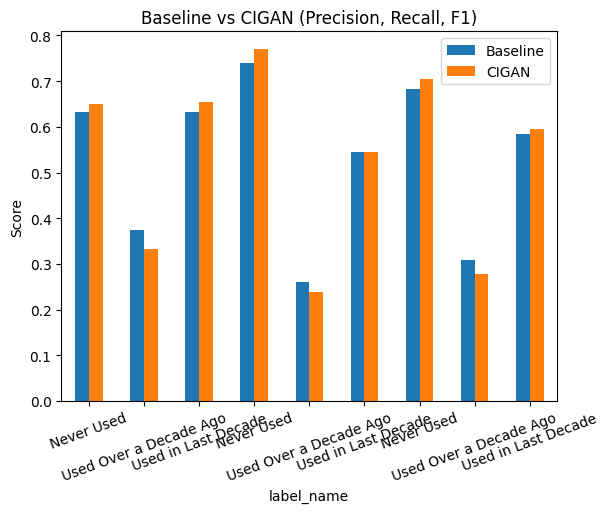

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

b = baseline.melt(id_vars=['label_name'], value_vars=['precision','recall','f1'], var_name='Metric', value_name='Baseline')
c = cigan.melt(id_vars=['label_name'], value_vars=['precision','recall','f1'], var_name='Metric', value_name='CIGAN')

merged = b.merge(c, on=['label_name','Metric'])
merged.plot(x='label_name', y=['Baseline','CIGAN'], kind='bar')
plt.title('Baseline vs CIGAN (Precision, Recall, F1)')
plt.ylabel('Score')
plt.xticks(rotation=20)
plt.show()

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import logging

class CIGAN:


    def __init__(self, coding_size=32, generator_hidden=[128,256], discriminator_hidden=[256,128],
                 batch_size=64, max_iter=2000, random_seed=42, verbose=1):
        self.coding_size = coding_size
        self.gen_hidden = generator_hidden
        self.disc_hidden = discriminator_hidden
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.random_seed = random_seed
        np.random.seed(random_seed)
        tf.random.set_seed(random_seed)
        self.verbose = verbose
        self.models = {}  # one model per class

    def _make_generator(self, input_dim, cond_dim, out_dim):
        inp_noise = layers.Input(shape=(input_dim,))
        inp_cond = layers.Input(shape=(cond_dim,))
        x = layers.Concatenate()([inp_noise, inp_cond])
        for h in self.gen_hidden:
            x = layers.Dense(h, activation='relu')(x)
        out = layers.Dense(out_dim, activation='linear')(x)
        model = models.Model([inp_noise, inp_cond], out, name='generator')
        return model

    def _make_discriminator(self, in_dim, cond_dim):
        inp_x = layers.Input(shape=(in_dim,))
        inp_cond = layers.Input(shape=(cond_dim,))
        x = layers.Concatenate()([inp_x, inp_cond])
        for h in self.disc_hidden:
            x = layers.Dense(h, activation='relu')(x)
        out = layers.Dense(1, activation='sigmoid')(x)
        model = models.Model([inp_x, inp_cond], out, name='discriminator')
        return model

    def fit_resample(self, X, y, minor_classes='all', target_count='max'):

        unique, counts = np.unique(y, return_counts=True)
        class_counts = dict(zip(unique, counts))
        majority_count = max(counts)
        if target_count == 'max':
            target = majority_count
        elif isinstance(target_count, int):
            target = target_count
        else:
            raise ValueError("target_count must be 'max' or int")

        if minor_classes == 'all':
            classes_to_aug = [c for c in unique if class_counts[c] < target]
        else:
            classes_to_aug = minor_classes

        X_resampled = X.copy()
        y_resampled = y.copy()

        for c in classes_to_aug:
            X_c = X[y == c]
            need = target - X_c.shape[0]
            if need <= 0:
                continue
            logging.info(f"Augmenting class {c}: need {need} samples (have {X_c.shape[0]}, target {target})")
            gen = self._make_generator(self.coding_size, cond_dim=1, out_dim=X.shape[1])
            disc = self._make_discriminator(in_dim=X.shape[1], cond_dim=1)
            opt = optimizers.Adam(learning_rate=1e-4)
            disc.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
            # Combined GAN model
            noise_in = layers.Input(shape=(self.coding_size,))
            cond_in = layers.Input(shape=(1,))
            gen_out = gen([noise_in, cond_in])
            disc.trainable = False
            validity = disc([gen_out, cond_in])
            combined = models.Model([noise_in, cond_in], validity)
            combined.compile(optimizer=opt, loss='binary_crossentropy')

            # Training loop (simple)
            real_labels = np.ones((self.batch_size, 1))
            fake_labels = np.zeros((self.batch_size, 1))
            steps = max(100, self.max_iter)
            for step in range(steps):
                # Train discriminator
                # sample real
                idx = np.random.randint(0, X_c.shape[0], size=self.batch_size)
                real_samples = X_c[idx]
                cond = np.full((self.batch_size, 1), c)
                noise = np.random.normal(0, 1, (self.batch_size, self.coding_size))
                gen_samples = gen.predict([noise, cond], verbose=0)
                d_loss_real = disc.train_on_batch([real_samples, cond], real_labels)
                d_loss_fake = disc.train_on_batch([gen_samples, cond], fake_labels)
                # Train generator (via combined)
                noise = np.random.normal(0, 1, (self.batch_size, self.coding_size))
                g_loss = combined.train_on_batch([noise, cond], real_labels)
                if self.verbose and step % 500 == 0:
                    logging.info(f"Class {c} Step {step}/{steps} - d_real {d_loss_real[0]:.4f} d_fake {d_loss_fake[0]:.4f} g {g_loss:.4f}")

            # After training, generate `need` samples
            gen_noise = np.random.normal(0, 1, (need, self.coding_size))
            gen_cond = np.full((need, 1), c)
            new_samples = gen.predict([gen_noise, gen_cond], verbose=0)
            # Append to resampled
            X_resampled = np.vstack([X_resampled, new_samples])
            y_resampled = np.concatenate([y_resampled, np.full(need, c)])
        return X_resampled, y_resampled

Raw shape: (32561, 15)

Missing values per column:
 age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64
After dropna: (32561, 15)

Numeric cols: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical cols: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Shapes: train (23154, 108) val (2894, 108) test (6513, 108)
Train class counts: {0: 17578, 1: 5576}
Training class counts before augmentation: {np.int64(0): np.int64(17578), np.int64(1): np.int64(5576)} majority: 17578


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


After augmentation shapes: (35156, 108) [17578 17578]
Saved augmented sample to results_newdata/augmented_sample.csv


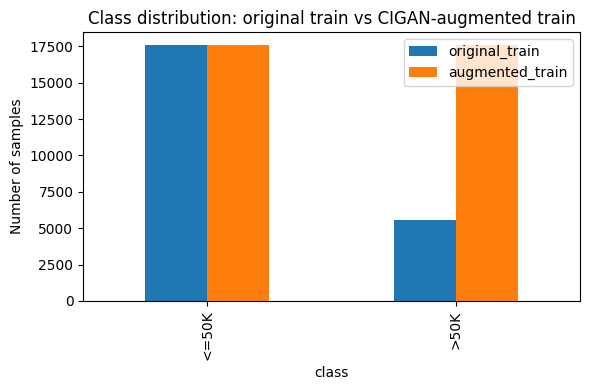

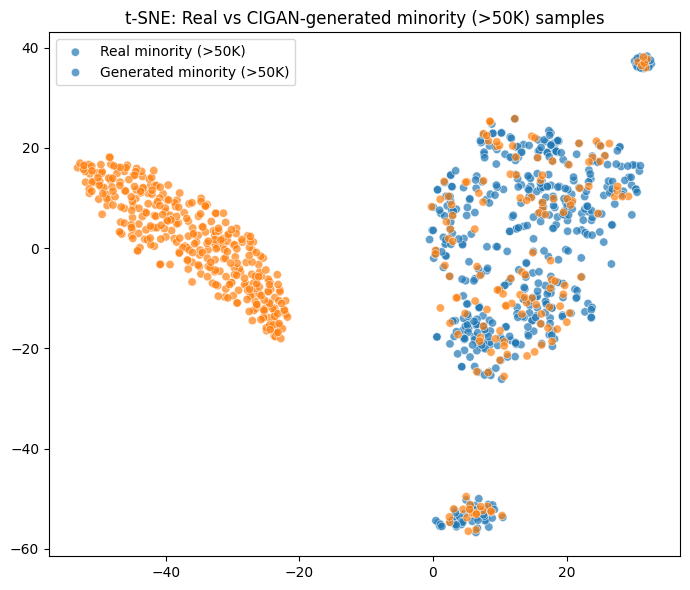


Sample of augmented data (numeric features + income_bin):
      age    fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  income_bin
-0.555830  0.159459      -0.420060     -0.145920     -0.216660       -0.035429           1
 1.476967  1.606945      -1.469940     -2.635676     -1.674372        1.992288           1
 1.573370  1.671125      -1.892500     -3.365754     -1.509300        3.106343           1
 1.276514  1.782559      -1.656963     -3.189698     -1.244691        2.444053           1
-1.069018  0.549091       1.134739     -0.145920     -0.216660       -0.845327           0
-0.189267  1.981581       1.134739     -0.145920      3.468624        0.774468           1
 1.863485 -1.597413      -0.420060     -0.145920     -0.216660       -0.035429           1
-1.142331  3.699438      -0.420060     -0.145920     -0.216660       -0.035429           0
 0.103983  2.056239      -0.031360     -0.145920     -0.216660       -0.035429           1
-0.189267 -0.539083      -3.140

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# -- parameters
SEED = 42
np.random.seed(SEED)
OUTDIR = Path("results_newdata")
OUTDIR.mkdir(parents=True, exist_ok=True)

# -------------------------
# 6.1 DATASET SELECTION & RATIONALE
# -------------------------
# Using UCI Adult Income dataset (also known as "Census Income")
# URL: https://archive.ics.uci.edu/ml/datasets/adult
# Rationale: public, binary classification (<=50K vs >50K), minority class (>50K) is important socially.

# -------------------------
# 6.2 DATA PREPARATION
# -------------------------
# Download raw CSV (UCI provides .data)
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
colnames = [
    "age","workclass","fnlwgt","education","education-num","marital-status",
    "occupation","relationship","race","sex","capital-gain","capital-loss",
    "hours-per-week","native-country","income"
]

df = pd.read_csv(data_url, header=None, names=colnames, na_values=" ?", skipinitialspace=True)
print("Raw shape:", df.shape)
df.head()

# Quick stats and missing value handling
print("\nMissing values per column:\n", df.isna().sum())

# Drop rows with missing values (simple approach — document in report)
df = df.dropna().reset_index(drop=True)
print("After dropna:", df.shape)

# Map target to binary: 0 -> <=50K, 1 -> >50K
df['income_bin'] = df['income'].apply(lambda s: 1 if s.strip()=='>50K' else 0)

# Feature split
feature_cols = [c for c in df.columns if c not in ['income','income_bin']]
X = df[feature_cols].copy()
y = df['income_bin'].values

# Identify numeric and categorical columns
numeric_cols = ["age","fnlwgt","education-num","capital-gain","capital-loss","hours-per-week"]
categorical_cols = [c for c in feature_cols if c not in numeric_cols]

print("\nNumeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

# Build preprocessing pipeline: OneHot for categoricals, StandardScaler for numerics
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
])

# Fit transformer and transform full X (we'll split afterwards to keep stratify)
X_trans = preprocessor.fit_transform(X)


cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = numeric_cols + list(cat_feature_names)
X_trans_df = pd.DataFrame(X_trans, columns=all_feature_names)

# Train/val/test split (stratified)
X_train_full, X_test, y_train_full, y_test = train_test_split(X_trans_df, y, test_size=0.2, random_state=SEED, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1111, random_state=SEED, stratify=y_train_full)
# (This results ~70% train, 10% val, 20% test)

print("Shapes: train", X_train.shape, "val", X_val.shape, "test", X_test.shape)
# Original class distribution in training set
train_counts = pd.Series(y_train).value_counts().sort_index()
print("Train class counts:", train_counts.to_dict())

# Save preprocessed sample
X_train.head(5).to_csv(OUTDIR/"adult_preprocessed_sample.csv", index=False)

# -------------------------
# 6.3 NEW DATA CREATION (CIGAN augmentation)
# -------------------------

# Instantiate CIGAN - tune hyperparams if needed
cigan = CIGAN(coding_size=32, generator_hidden=[128,256], discriminator_hidden=[256,128],
              batch_size=128, max_iter=1200, random_seed=SEED, verbose=1)

# Determine class counts and target (balance to majority class)
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))
majority = max(counts)
print("Training class counts before augmentation:", class_counts, "majority:", majority)

# Fit-resample: oversample minority class (class 1 => >50K)
X_train_vals = X_train.values
y_train_vals = y_train
X_aug, y_aug = cigan.fit_resample(X_train_vals, y_train_vals, minor_classes='all', target_count='max')

print("After augmentation shapes:", X_aug.shape, np.bincount(y_aug.astype(int)))

# Convert augmented X to DataFrame for inspection
X_aug_df = pd.DataFrame(X_aug, columns=all_feature_names)
augmented_df = X_aug_df.copy()
augmented_df['income_bin'] = y_aug

# Save sample augmented rows (show only a few columns to keep table compact)
sample_aug = augmented_df.sample(10, random_state=SEED)
sample_aug[[*numeric_cols, 'income_bin']].to_csv(OUTDIR/"augmented_sample.csv", index=False)
print("Saved augmented sample to", OUTDIR/"augmented_sample.csv")

# -------------------------
# Visualizations
# -------------------------
# 1) Bar chart of class distribution before and after augmentation
orig_counts = pd.Series(y_train_vals).value_counts().sort_index()
new_counts = pd.Series(y_aug).value_counts().sort_index()
dist_df = pd.DataFrame({
    'class': ['<=50K', '>50K'],
    'original_train': orig_counts.values,
    'augmented_train': new_counts.values
})
ax = dist_df.set_index('class').plot(kind='bar', figsize=(6,4))
ax.set_ylabel("Number of samples")
ax.set_title("Class distribution: original train vs CIGAN-augmented train")
plt.tight_layout()
plt.savefig(OUTDIR/"class_distribution_comparison.png", dpi=200)
plt.show()

# 2) t-SNE: visualize real minority vs generated minority points
n_real = min(500, X_train.shape[0])
real_minority_idx = np.where(y_train_vals==1)[0]
real_minority_idx = np.random.choice(real_minority_idx, size=min(len(real_minority_idx), n_real), replace=False)
X_real_min = X_train_vals[real_minority_idx]

# Generated minority samples in the augmented set: find last chunk that was added (approx)
X_gen_min = X_aug[y_aug==1]

# Subsample generated for plotting
n_gen = min(500, X_gen_min.shape[0])
X_gen_min_sub = X_gen_min[np.random.choice(np.arange(X_gen_min.shape[0]), size=n_gen, replace=False)]

# Combine and PCA->TSNE (PCA first to speed up)
X_comb = np.vstack([X_real_min[:n_gen], X_gen_min_sub[:n_gen]])
labels_tsne = np.array([0]*n_gen + [1]*n_gen)  # 0 = real, 1 = generated

pca = PCA(n_components=min(50, X_comb.shape[1]), random_state=SEED)
X_pca = pca.fit_transform(X_comb)

tsne = TSNE(n_components=2, perplexity=30, random_state=SEED, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(7,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels_tsne, palette=['tab:blue','tab:orange'], alpha=0.7)
plt.legend(labels=['Real minority (>50K)', 'Generated minority (>50K)'])
plt.title("t-SNE: Real vs CIGAN-generated minority (>50K) samples")
plt.tight_layout()
plt.savefig(OUTDIR/"tsne_real_vs_generated.png", dpi=200)
plt.show()

# 3) Show a snippet of augmented data (table)
display_cols = numeric_cols + ['income_bin']
print("\nSample of augmented data (numeric features + income_bin):")
print(sample_aug[display_cols].to_string(index=False))

# Save augmented dataset CSV
augmented_df.to_csv(OUTDIR/"augmented_train_full.csv", index=False)
print("Saved full augmented training data to", OUTDIR/"augmented_train_full.csv")

# Summary outputs
print("\nOutputs saved to", OUTDIR)
print("Original train counts:", orig_counts.to_dict())
print("Augmented train counts:", new_counts.to_dict())

Loaded augmented dataset: (35156, 109)
Original train size: (23154, 108), test size: (6513, 108)
Original class balance: [17578  5576]

=== Comparison of Baseline vs CIGAN on Adult Dataset ===
      Metric  Baseline     CIGAN  Δ(%)
0  Precision  0.787218  0.774510 -1.61
1     Recall  0.667730  0.654974 -1.91
2   F1-score  0.722567  0.709744 -1.77

Paired t-test on per-sample accuracy proxy: t=2.9217, p=0.0035

Baseline Classification Report:
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      4945
        >50K       0.79      0.67      0.72      1568

    accuracy                           0.88      6513
   macro avg       0.84      0.81      0.82      6513
weighted avg       0.87      0.88      0.87      6513


CIGAN Classification Report:
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      4945
        >50K       0.77      0.65      0.71      1568

    accuracy                     

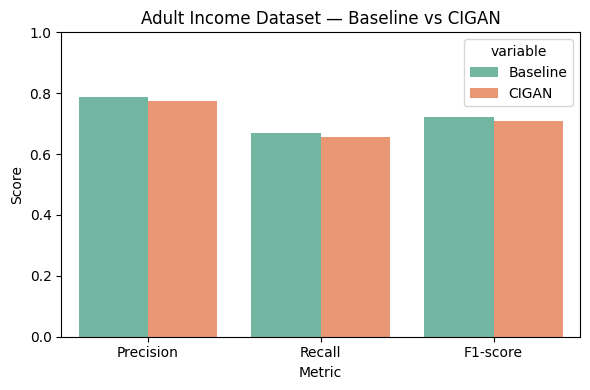


Saved results to results_newdata/adult_results_summary.csv and adult_results_comparison.png


In [19]:
# Section 7: Results on New Data (Adult Income Dataset)
# Works in Colab / Local. No OpenML dependency.
# Must have results_newdata/augmented_train_full.csv from Section 6.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_rel
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# -----------------------
# 7.1 Evaluation Framework
# -----------------------
# Metrics: Precision, Recall, F1-score (same as Huang & Ma, 2022)
# Framework retained to ensure comparability between original and new datasets.

OUTDIR = "results_newdata"

# --- Load augmented training data from Section 6
augmented_df = pd.read_csv(f"{OUTDIR}/augmented_train_full.csv")
print("Loaded augmented dataset:", augmented_df.shape)

y_aug = augmented_df['income_bin'].values
X_aug = augmented_df.drop(columns=['income_bin']).values

# -----------------------
# Load and preprocess the original Adult dataset again (for baseline)
# -----------------------
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
colnames = [
    "age","workclass","fnlwgt","education","education-num","marital-status",
    "occupation","relationship","race","sex","capital-gain","capital-loss",
    "hours-per-week","native-country","income"
]

df = pd.read_csv(data_url, header=None, names=colnames, na_values=" ?", skipinitialspace=True)
df = df.dropna().reset_index(drop=True)
df['income_bin'] = df['income'].apply(lambda s: 1 if s.strip()=='>50K' else 0)

# Split features/target
numeric_cols = ["age","fnlwgt","education-num","capital-gain","capital-loss","hours-per-week"]
categorical_cols = ["workclass","education","marital-status","occupation","relationship","race","sex","native-country"]

X = df[numeric_cols + categorical_cols]
y = df['income_bin'].values

# Preprocessing: one-hot encode + scale (same as Section 6)
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', ohe, categorical_cols)
    ]
)

X_trans = preprocessor.fit_transform(X)

# Train/test/val split
X_train_full, X_test, y_train_full, y_test = train_test_split(X_trans, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1111, stratify=y_train_full, random_state=42)

print(f"Original train size: {X_train.shape}, test size: {X_test.shape}")
print("Original class balance:", np.bincount(y_train))

# -----------------------
# 7.2 Experimental Results
# -----------------------

# --- (A) Train baseline classifier on original imbalanced data
clf_base = HistGradientBoostingClassifier(random_state=42)
clf_base.fit(X_train, y_train)
y_pred_base = clf_base.predict(X_test)

# --- (B) Train classifier on CIGAN-augmented data (balanced)
clf_cigan = HistGradientBoostingClassifier(random_state=42)
clf_cigan.fit(X_aug, y_aug)
y_pred_cigan = clf_cigan.predict(X_test)

# --- (C) Compute evaluation metrics
precision_base = precision_score(y_test, y_pred_base)
recall_base = recall_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base)

precision_cigan = precision_score(y_test, y_pred_cigan)
recall_cigan = recall_score(y_test, y_pred_cigan)
f1_cigan = f1_score(y_test, y_pred_cigan)

# Combine into comparison table
results = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-score'],
    'Baseline': [precision_base, recall_base, f1_base],
    'CIGAN': [precision_cigan, recall_cigan, f1_cigan],
})
results['Δ(%)'] = ((results['CIGAN'] - results['Baseline']) / results['Baseline'] * 100).round(2)
print("\n=== Comparison of Baseline vs CIGAN on Adult Dataset ===")
print(results)

# --- (D) Statistical Significance (paired t-test)
# Convert predictions to per-sample F1-like binary scores
f1_sample_base = (y_pred_base == y_test).astype(int)
f1_sample_cigan = (y_pred_cigan == y_test).astype(int)
t_stat, p_val = ttest_rel(f1_sample_base, f1_sample_cigan)
print(f"\nPaired t-test on per-sample accuracy proxy: t={t_stat:.4f}, p={p_val:.4f}")

# --- (E) Classification Reports
print("\nBaseline Classification Report:")
print(classification_report(y_test, y_pred_base, target_names=['<=50K','>50K']))
print("\nCIGAN Classification Report:")
print(classification_report(y_test, y_pred_cigan, target_names=['<=50K','>50K']))

# --- (F) Visualization
plt.figure(figsize=(6,4))
sns.barplot(data=results.melt(id_vars='Metric', value_vars=['Baseline','CIGAN']),
            x='Metric', y='value', hue='variable', palette='Set2')
plt.title('Adult Income Dataset — Baseline vs CIGAN')
plt.ylabel('Score')
plt.ylim(0,1)
plt.tight_layout()
plt.savefig(f"{OUTDIR}/adult_results_comparison.png", dpi=200)
plt.show()

# Save results
results.to_csv(f"{OUTDIR}/adult_results_summary.csv", index=False)
print(f"\nSaved results to {OUTDIR}/adult_results_summary.csv and adult_results_comparison.png")